# Ahmad Task 18 - Motor Control
### Introduction to modeling and simulation of human movement
https://github.com/BMClab/bmc/blob/master/courses/ModSim2018.md

Implement a simulation of the ankle joint model using the parameters from Thelen (2003) and Elias (2014)

In [1]:
import numpy as np
import pandas as pd
import scipy.signal
%matplotlib notebook
import matplotlib.pyplot as plt
import math
from Muscle import Muscle

In [2]:
Lslack = 2.4*0.09 # tendon slack length
Lce_o  = 0.09 # optimal muscle fiber length
Fmax   = 1400 #maximal isometric DF force
alpha  = 7*math.pi/180 # DF muscle fiber pennation angle

dt = 0.001

In [3]:
dorsiflexor = Muscle(Lce_o=Lce_o, Fmax=Fmax, Lslack=Lslack, alpha=alpha, dt = dt)
soleus = Muscle(Lce_o=0.049, Fmax=8050, Lslack=0.289, alpha=25*np.pi/180, dt =  dt)

In [4]:
soleus.Fmax

8050

### Muscle properties

Parameters from Nigg & Herzog (2006).

In [5]:
Umax  = 0.04 # SEE strain at Fmax
width = 0.63 # Max relative length change of CE

Activation dynamics parameters

In [6]:
a = 1
u = 1 #Initial conditional for Brain's activation
#b = .25*10#*Lce_o 

## Subject's anthropometrics
Parameters obtained experimentally or from Winter's book.

In [7]:
M      = 75 #total body mass (kg)
Lseg   = 0.26 #segment length (m)
m      = 1*M #foot mass (kg)
g      = 9.81 #acceleration of gravity (m/s2)
hcm    = 0.85 #distance from ankle joint to center of mass (m)
I      = (4/3)*m*hcm**2 #moment of inertia
legAng = math.pi/2 #angle of the leg with horizontal (90 deg)

In [8]:
As_TA = np.array([30.6, -7.44e-2, -1.41e-4, 2.42e-6, 1.5e-8]) / 100   # at [m] instead of [cm]
# Coefs for moment arm for ankle angle
Bs_TA = np.array([4.3, 1.66e-2, -3.89e-4, -4.45e-6, -4.34e-8]) / 100  # at [m] instead of [cm]
As_SOL = np.array([32.3, 7.22e-2, -2.24e-4, -3.15e-6, 9.27e-9]) / 100   # at [m] instead of [cm]
Bs_SOL = np.array([-4.1, 2.57e-2, 5.45e-4, -2.22e-6, -5.5e-9]) / 100   # at [m] instead of [cm]

### Initial conditions

In [9]:
phi = 5*np.pi/180
phid = 0 #zero velocity
Lm0  = 0.306 #initial total lenght of the muscle
dorsiflexor.Lnorm_ce = 1
soleus.Lnorm_ce = 1
t0 = 0 #Initial time
tf = 30 #Final Time
dt=0.001

In [10]:

t = np.arange(t0,tf,dt) # time array
# preallocating
F          = np.empty((t.shape[0],2))
phivec     = np.empty(t.shape)
Fkpe       = np.empty(t.shape)
FiberLen   = np.empty((t.shape[0],2))
TendonLen  = np.empty(t.shape)
a_dynamics = np.empty((t.shape[0],2))
Moment     = np.empty(t.shape)

## Simulation - Series

In [11]:
def momentArmDF(phi):
    '''
    Calculate the tibialis anterior moment arm according to Elias et al (2014)
    Input: 
    phi: Ankle joint angle in radians
    Output:
    Rarm: TA moment arm
    '''
    # Consider neutral ankle position as zero degrees
    phi = phi*180/np.pi # converting to degrees
    Rf = 4.3 + 1.66E-2*phi + -3.89E-4*phi**2 + -4.45E-6*phi**3 + -4.34E-8*phi**4
    Rf = Rf/100 # converting to meters
    return Rf

In [12]:
def ComputeTotalLengthSizeTA(phi):
    '''
    Calculate TA MTU length size according to Elias et al (2014)
    Input: 
    phi: ankle angle
    '''
    phi = phi*180/math.pi # converting to degrees
    Lm = 30.6 + -7.44E-2*phi + -1.41E-4*phi**2 + 2.42E-6*phi**3 + 1.5E-8*phi**4
    Lm = Lm/100
    return Lm

In [13]:
def ComputeMomentJoint(Rf_TA, Fnorm_tendon_TA, Fmax_TA, Rf_SOL, Fnorm_tendon_SOL, Fmax_SOL, m, g, phi):
    '''
    Inputs:
        RF = Moment arm
        Fnorm_tendon = Normalized tendon force
        m = Segment Mass
        g = Acelleration of gravity
        Fmax= maximal isometric force
    Output:
        M = Total moment with respect to joint
    '''
    M = (-0.65*m*g*hcm*phi +Rf_TA*Fnorm_tendon_TA*Fmax_TA 
    + Rf_SOL*Fnorm_tendon_SOL*Fmax_SOL + m*g*hcm*np.sin(phi))
    return M

In [14]:
def ComputeAngularAcelerationJoint(M, I):
    '''
    Inputs:
        M = Total moment with respect to joint
        I = Moment of Inertia
    Output:
        phidd= angular aceleration of the joint
    '''
    phidd = M/I
    return phidd

In [15]:
def computeMomentArmJoint(theta, Bs):
    # theta - joint angle (degrees)
    # Bs - coeficients for the polinomio

    auxBmultp = np.empty(Bs.shape);
    for i in range (len(Bs)):
        auxBmultp[i] = Bs[i] * (theta**i)

    Rf = sum(auxBmultp)

    return Rf

In [16]:
def ComputeTotalLenghtSize(theta, As):
        # theta = joint angle(degrees)
        # As - coeficients for the polinomio

        auxAmultp = np.empty(As.shape);

        for i in range (len(As)):
            auxAmultp[i] = As[i] * (theta**i)

        Lm = sum(auxAmultp)

        return Lm

In [17]:
Lce_TA_ref = 0.086
Lce_SOL_ref = 0.037
noise=0.1*np.random.randn(len(t))*1/dt * 0
[b,a] = scipy.signal.butter(2,40.0/(1/dt/2))
#filtNoise = scipy.signal.filtfilt(b,a,noise)
filtNoise = noise
phiRef=5*np.pi/180
Kp_TA=1000
Kd_TA=50
Kp_SOL=1000
Kd_SOL=50
for i in range (len(t)):
    Lm_TA = ComputeTotalLenghtSize(phi*180/np.pi, As_TA)
    Rf_TA = computeMomentArmJoint(phi*180/np.pi, Bs_TA)
    Lm_SOL = ComputeTotalLenghtSize(phi*180/np.pi, As_SOL)
    Rf_SOL = computeMomentArmJoint(phi*180/np.pi, Bs_SOL)
    ##################################################################
    
#    e = phiRef - phi
#    if e>0:
#        U_TA, U_SOL = max(min(1, Kp*e-Kd*phid), 0.01), 0.01
#    else:
#        U_TA, U_SOL = 0.01, max(min(1, -Kp*e+Kd*phid), 0.01) 
    
    e_TA = Lce_TA_ref - dorsiflexor.Lnorm_ce*dorsiflexor.Lce_o
    if e_TA > 0:
        U_TA = 0.01
    else:
        U_TA = max(min(1, -Kp_TA*e_TA+Kd_TA*dorsiflexor.Lnorm_cedot*dorsiflexor.Lce_o), 0.01)     
    e_SOL = Lce_SOL_ref - soleus.Lnorm_ce*soleus.Lce_o
    if e_SOL > 0:
        U_SOL = 0.01
    else:
        U_SOL = max(min(1, -Kp_SOL*e_SOL+Kd_SOL*soleus.Lnorm_cedot*soleus.Lce_o), 0.01)     
    
    ##############################################################
    dorsiflexor.updateMuscle(Lm=Lm_TA, u=U_TA)
    soleus.updateMuscle(Lm=Lm_SOL, u=U_SOL)
    #####################################################################     
    #Compute MomentJoint
    M = ComputeMomentJoint(Rf_TA,dorsiflexor.Fnorm_tendon,
                           dorsiflexor.Fmax,
                           Rf_SOL, soleus.Fnorm_tendon,
                           soleus.Fmax,
                           m,g,phi)
    #Compute Angular Aceleration Joint

    torqueWithNoise = M + filtNoise[i] 
    phidd = ComputeAngularAcelerationJoint (torqueWithNoise,I)
    # Euler integration steps
    phid= phid + dt*phidd
    phi  = phi  + dt*phid
    phideg= (phi*180)/math.pi #convert joint angle from radians to degree
    # Store variables in vectors
    F[i,0] = dorsiflexor.Fnorm_tendon*dorsiflexor.Fmax
    F[i,1] = soleus.Fnorm_tendon*soleus.Fmax
    Fkpe[i] = dorsiflexor.Fnorm_kpe*dorsiflexor.Fmax
    FiberLen[i,0] = dorsiflexor.Lnorm_ce*dorsiflexor.Lce_o
    FiberLen[i,1] = soleus.Lnorm_ce*soleus.Lce_o
    TendonLen[i] = dorsiflexor.Lnorm_see*dorsiflexor.Lce_o
    a_dynamics[i,0] = dorsiflexor.a
    a_dynamics[i,1] = soleus.a
    phivec[i] = phideg
    Moment[i] = M

## Plots 

<IPython.core.display.Javascript object>


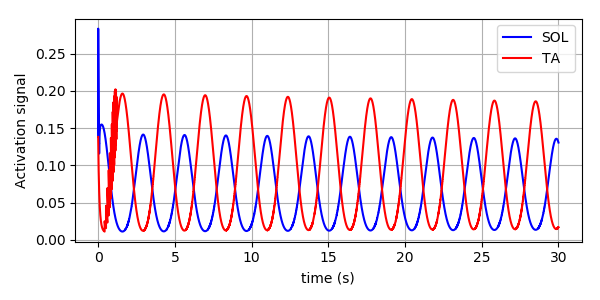

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(6,3))


ax.plot(t,a_dynamics[:,1],c='blue', label='SOL')
ax.plot(t,a_dynamics[:,0],c='red', label='TA')
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('Activation signal')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


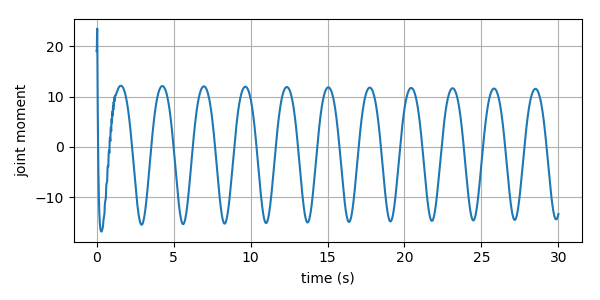

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(6,3))

ax.plot(t, Moment)
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('joint moment')
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


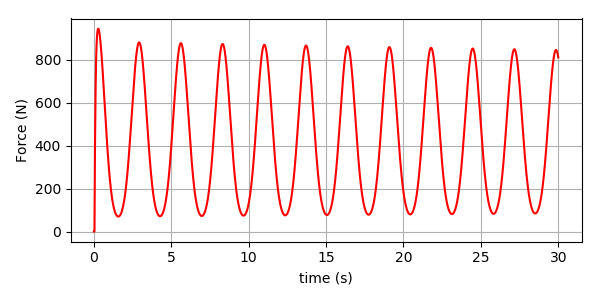

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(6,3))

ax.plot(t, F[:,1], c='red')
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('Force (N)')
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


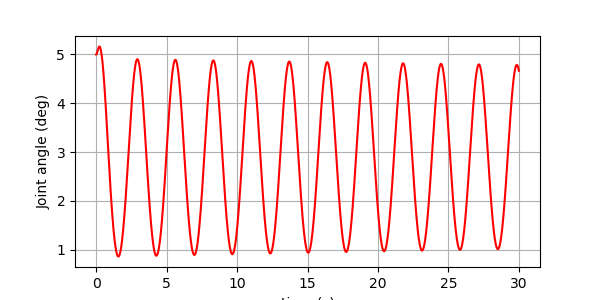

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(6,3))

ax.plot(t,phivec,c='red')
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('Joint angle (deg)')
plt.show()

<IPython.core.display.Javascript object>


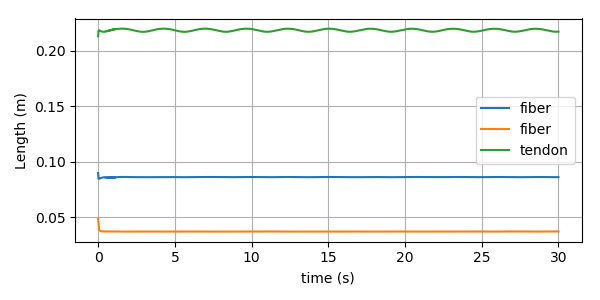

<IPython.core.display.Javascript object>


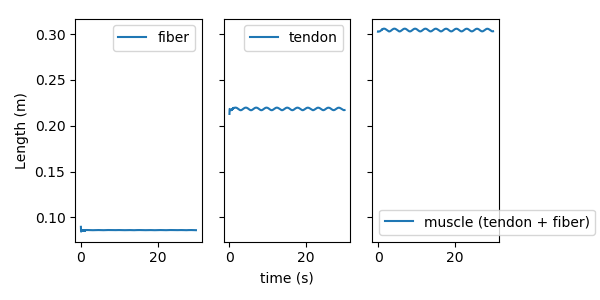

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(6,3))

ax.plot(t,FiberLen, label = 'fiber')
ax.plot(t,TendonLen, label = 'tendon')
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('Length (m)')
ax.legend(loc='best')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 3, figsize=(6,3), sharex=True, sharey=True)
ax[0].plot(t,FiberLen[:,0], label = 'fiber')
ax[1].plot(t,TendonLen, label = 'tendon')
ax[2].plot(t,FiberLen[:, 0] + TendonLen, label = 'muscle (tendon + fiber)')

ax[1].set_xlabel('time (s)')
ax[0].set_ylabel('Length (m)')
ax[0].legend(loc='best')
ax[1].legend(loc='best')
ax[2].legend(loc='best')
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


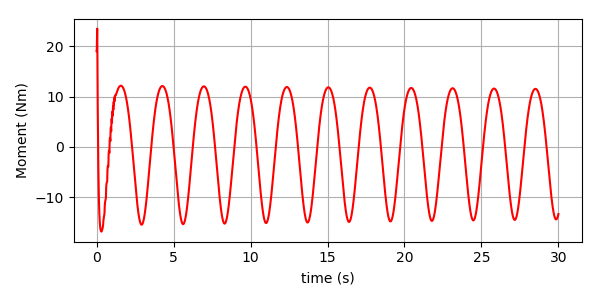

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(6,3))

ax.plot(t,Moment,c='red')
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('Moment (Nm)')
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


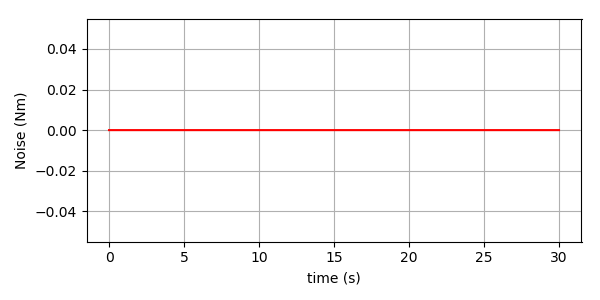

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(6,3))

ax.plot(t,filtNoise*dt,c='red')
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('Noise (Nm)')
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


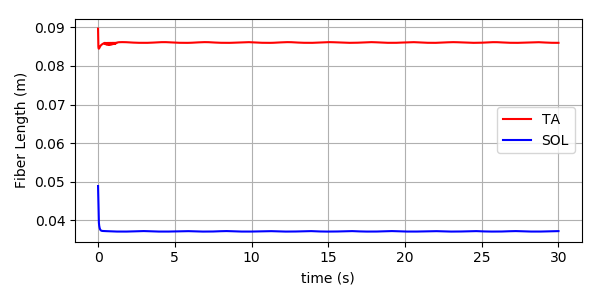

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(6,3))

ax.plot(t,FiberLen[:,0],c='red', label='TA')
ax.plot(t,FiberLen[:,1],c='blue', label='SOL')
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('Fiber Length (m)')
plt.legend(loc='best')
plt.tight_layout()
plt.show()